
# **Previsão de Falhas em Motores com Dados da NASA**

Este projeto tem como objetivo aplicar técnicas de **mineração de dados e modelagem preditiva** para estimar a **vida útil restante (RUL - Remaining Useful Life)** de motores a jato. Utilizamos dados simulados pela NASA através do modelo **C-MAPSS (Commercial Modular Aero-Propulsion System Simulation)**, amplamente adotado em estudos de **manutenção preditiva**.

O conjunto de dados contém informações de sensores coletadas ao longo do tempo durante a operação de diversos motores turbofan, até o momento da falha. Nesta etapa inicial, focaremos no subconjunto **FD001**, que apresenta uma única condição operacional e um único modo de falha.  


---

## Sobre o Conjunto de Dados

- **Fonte**: [Kaggle - NASA C-MAPSS Dataset](https://www.kaggle.com/datasets/behrad3d/nasa-cmaps)
- **Formato**: Arquivos `.txt`, separados por espaços.
- **Conteúdo**:
  - `train_FD001.txt`: dados de treinamento (ciclos completos dos motores até falharem)
  - `test_FD001.txt`: dados de teste (ciclos parciais, até um certo ponto)
  - `RUL_FD001.txt`: vida útil restante real dos motores no conjunto de teste

Cada linha dos arquivos representa a leitura de um motor em um determinado ciclo e contém:
- Identificador do motor (`unit number`)
- Ciclo de operação (`time in cycles`)
- Três configurações operacionais (`setting_1`, `setting_2`, `setting_3`)
- 21 sensores com medidas de desempenho

---

A seguir, realizamos o **download automático dos dados**, organizamos os arquivos e carregamos o subconjunto FD001 para análise.


In [114]:
%matplotlib inline

# --- Bibliotecas padrão ---
import os
import random
import warnings

# --- Bibliotecas científicas ---
import numpy as np
import pandas as pd

# --- Visualização ---
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# --- Machine Learning ---
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Kaggle ---
import kagglehub

# --- Configurações globais ---
np.random.seed(34)
warnings.filterwarnings('ignore')


In [88]:


# Baixando o conjuto de dados
path = kagglehub.dataset_download("behrad3d/nasa-cmaps")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/nasa-cmaps


In [89]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nasa-cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/x.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt


In [90]:

# Caminho base para os arquivos
link_url = os.path.join(path, 'CMaps') + '/'

# Carregar arquivos FD001
train = pd.read_csv(link_url + 'train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv(link_url + 'test_FD001.txt', sep='\s+', header=None)
y_test = pd.read_csv(link_url + 'RUL_FD001.txt', sep='\s+', header=None)

train.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...      16       17       18      19    20   21    22     23     24  \
0  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

        25  
0  23.4190  
1  23.4236  
2  23.3442  
3  23.3739  
4  23.4044  

[5 rows x 26 columns]

**Renomeando as Colunas para Melhor Compreensão**

O conjunto de dados original não possui cabeçalhos e apresenta as colunas numeradas de 0 a 25. Para facilitar a análise e a interpretação, vamos atribuir nomes mais descritivos às colunas com base na documentação do C-MAPSS.

A estrutura dos dados é a seguinte:

1. `unit_nr`: Identificador do motor (unidade)
2. `time_cycles`: Tempo em ciclos de operação
3. `setting_1`, `setting_2`, `setting_3`: Três configurações operacionais
4. `s_1` a `s_21`: Leituras dos sensores embarcados no motor

Esses nomes nos permitirão trabalhar de forma mais intuitiva e clara ao longo da análise, sem depender da posição numérica das colunas.


In [91]:


# Nomes das colunas
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

# Carregar arquivos FD001
train = pd.read_csv(link_url + 'train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv(link_url + 'test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(link_url + 'RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

train.head()


unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    -0.0007    -0.0004      100.0  518.67  641.82   
1        1            2     0.0019    -0.0003      100.0  518.67  642.15   
2        1            3    -0.0043     0.0003      100.0  518.67  642.35   
3        1            4     0.0007     0.0000      100.0  518.67  642.35   
4        1            5    -0.0019    -0.0002      100.0  518.67  642.37   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03   392   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03   392   
2  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03   390   
3  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03   392   
4  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03   393   

   s_18   s_19   s_20     s_21  
0  2388  100.0  39.06  23.4190  
1  2388  100.0  39.00  23.4236  
2  2388  100.0  38.95  23.3442  
3  2388  100.0  38.88  23.3739  
4  2388  100.0  38.90  23.4044  

[5 rows x 26 columns]

Agora que já carregamos e estruturamos o conjunto de dados, vamos explorar algumas estatísticas descritivas iniciais. O objetivo aqui é confirmar se realmente temos registros para 100 motores distintos e entender como varia a quantidade de ciclos de operação (`time_cycles`) até que cada motor falhe. Essa análise nos ajuda a ter uma noção da vida útil média dos motores, além de revelar possíveis variações relevantes entre eles, que podem ser importantes para o processo de modelagem mais à frente.

In [92]:
train[index_names].describe()

unit_nr   time_cycles
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

Aqui mostra que temos um total de 20631 registros de leitura em todo o conjunto de treinamento. A coluna unit_nr varia de 1 a 100, e a coluna time_cycles varia de 1 a 362. A média de ciclos por registro é de aproximadamente 108.8.

In [93]:
train[index_names].groupby('unit_nr').max().describe()

time_cycles
count   100.000000
mean    206.310000
std      46.342749
min     128.000000
25%     177.000000
50%     199.000000
75%     229.250000
max     362.000000

Aqui, após agrupar por unit_nr e pegar o max de time_cycles, é crucial. Ela confirma que há exatamente 100 motores distintos no conjunto de treinamento. A vida útil média dos motores (ciclos até a falha) é de aproximadamente 206.31 ciclos, com o motor que falhou mais cedo durando 128 ciclos e o motor mais durável operando por 362 ciclos. Essa informação sobre a distribuição da vida útil é fundamental para entender a variabilidade dos dados e para o desenvolvimento de modelos de previsão de RUL.

In [94]:
train[setting_names].describe()

setting_1     setting_2  setting_3
count  20631.000000  20631.000000    20631.0
mean      -0.000009      0.000002      100.0
std        0.002187      0.000293        0.0
min       -0.008700     -0.000600      100.0
25%       -0.001500     -0.000200      100.0
50%        0.000000      0.000000      100.0
75%        0.001500      0.000300      100.0
max        0.008700      0.000600      100.0

In [95]:
train[sensor_names].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184

Observando o desvio padrão, fica claro que os sensores 18 e 19 não apresentam flutuação alguma; eles podem ser descartados com segurança, pois não contêm informações úteis. Os sensores 6, 16, 17, 20 e 21 apresentam pouca flutuação e requerem inspeção mais aprofundada. Os sensores 9 e 14 apresentam a maior flutuação; no entanto, isso não significa que os outros sensores não possam conter informações valiosas.

Antes de começarmos a plotar nossos dados, calcularemos uma variável-alvo para a **Vida Útil Restante (RUL)** de cada motor ao longo do tempo, já que essa informação não está diretamente disponível no conjunto de dados.
Ela é essencial por dois motivos:

Análise dos sensores: A RUL permite visualizar como os sinais dos sensores se comportam à medida que o motor se aproxima da falha.

Aprendizado de máquina supervisionado: A RUL é usada como variável-alvo (label) no treinamento de modelos que tentam prever quando um motor irá falhar.

A suposição feita é que a RUL diminui linearmente: no último ciclo é 0, e aumenta retroativamente conforme o motor está mais distante da falha. Para isso, subtrui-se o ciclo atual do ciclo máximo de cada motor.

In [96]:
def adicionar_vida_util_restante(df):
    # Agrupar os dados por unidade (motor)
    agrupado_por_unidade = df.groupby(by="unit_nr")

    # Obter o número máximo de ciclos de tempo (último ciclo antes da falha) para cada motor
    ciclo_maximo = agrupado_por_unidade["time_cycles"].max()

    # Juntar o valor do ciclo máximo de volta ao DataFrame original
    df_com_ciclo_max = df.merge(ciclo_maximo.to_frame(name='ciclo_maximo'), left_on='unit_nr', right_index=True)

    # Calcular a vida útil restante (RUL) para cada linha: ciclo máximo - ciclo atual
    vida_util_restante = df_com_ciclo_max["ciclo_maximo"] - df_com_ciclo_max["time_cycles"]
    df_com_ciclo_max["RUL"] = vida_util_restante

    # Remover a coluna auxiliar 'ciclo_maximo', pois não é mais necessária
    df_com_ciclo_max = df_com_ciclo_max.drop("ciclo_maximo", axis=1)

    # Retornar o novo DataFrame com a coluna RUL adicionada
    return df_com_ciclo_max

# Aplicar a função ao conjunto de dados de treino
train = adicionar_vida_util_restante(train)

# Visualizar as primeiras linhas com as colunas de índice e RUL
train[index_names + ['RUL']].head()


unit_nr  time_cycles  RUL
0        1            1  191
1        1            2  190
2        1            3  189
3        1            4  188
4        1            5  187

# **Plotagem**

Histograma da RUL:


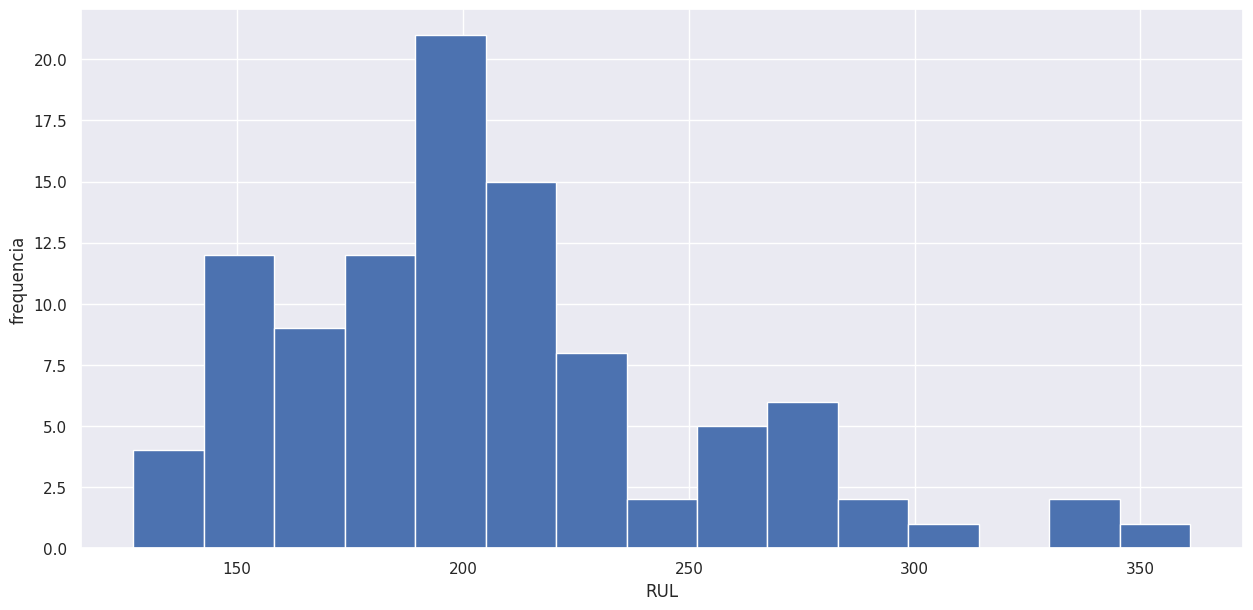

In [97]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequencia')
plt.show()

O histograma reconfirma que a maioria dos motores quebra em torno de 200 ciclos. Além disso, a distribuição é assimétrica à direita, com poucos motores durando mais de 300 ciclos.

In [98]:
maxrul_u = train.groupby('unit_nr').max().reset_index()
maxrul_u.head()

unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1          192     0.0047     0.0005      100.0  518.67  644.21   
1        2          287     0.0076     0.0006      100.0  518.67  643.94   
2        3          179     0.0058     0.0005      100.0  518.67  643.93   
3        4          189     0.0059     0.0006      100.0  518.67  644.53   
4        5          269     0.0055     0.0005      100.0  518.67  644.02   

       s_3      s_4    s_5  ...     s_13     s_14    s_15  s_16  s_17  s_18  \
0  1605.44  1432.52  14.62  ...  2388.35  8140.58  8.5227  0.03   398  2388   
1  1610.10  1431.17  14.62  ...  2388.26  8175.57  8.5377  0.03   398  2388   
2  1606.50  1438.51  14.62  ...  2388.20  8255.34  8.5363  0.03   399  2388   
3  1612.11  1434.12  14.62  ...  2388.17  8259.42  8.5462  0.03   399  2388   
4  1609.41  1434.59  14.62  ...  2388.23  8215.19  8.5410  0.03   398  2388   

    s_19   s_20     s_21  RUL  
0  100.0  39.18  23.4999  191  
1  100.0  39.24  23.6005  286  
2  100.0  39.23  23.5181  178  
3  100.0  39.21  23.5074  188  
4  100.0  39.29  23.5503  268  

[5 rows x 27 columns]

# **Grafico Sensores**
Como há muitos motores no dataset, plotar todos ao mesmo tempo deixaria o gráfico confuso e ilegível. Então, o código só plota os motores cujo unit_nr é divisível por 10 (unit_nr % 10 == 0), reduzindo o número de linhas no gráfico para algo interpretável.


In [99]:
def plotar_sensor(sensor_name):
    plt.figure(figsize=(13, 5))  # Define o tamanho da figura

    # Para cada motor único no conjunto de dados
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # Plota apenas os motores cujo número é divisível por 10
            plt.plot('RUL', sensor_name,
                     data=train[train['unit_nr'] == i])  # Plota a RUL contra o valor do sensor

    plt.xlim(250, 0)  # Inverte o eixo X para que a RUL vá de 250 até 0
    plt.xticks(np.arange(0, 275, 25))  # Define os intervalos no eixo X
    plt.ylabel(sensor_name)  # Nome do sensor no eixo Y
    plt.xlabel('Vida Útil Restante (RUL)')  # Rótulo do eixo X
    plt.title(f'Sinais do sensor: {sensor_name}')  # Título do gráfico
    plt.show()  # Exibe o gráfico


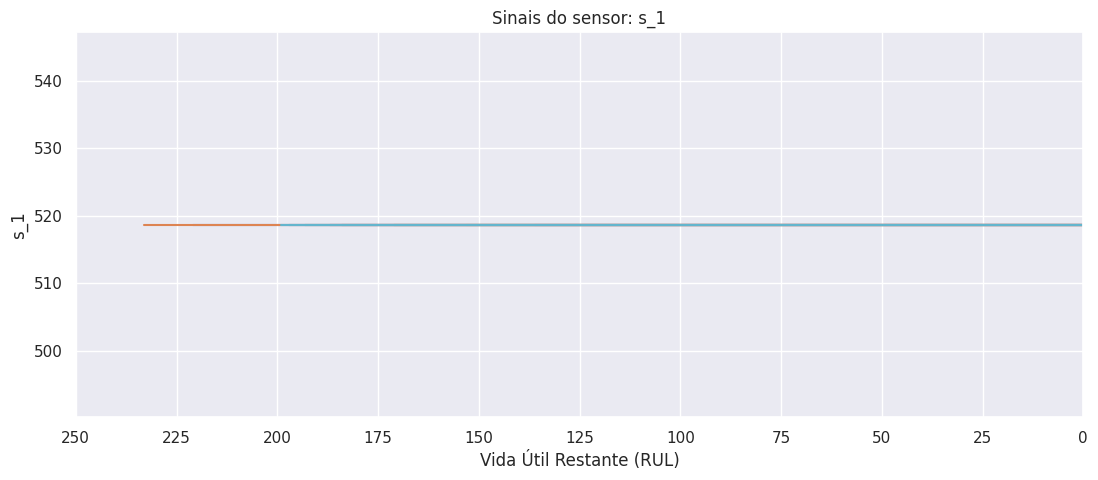

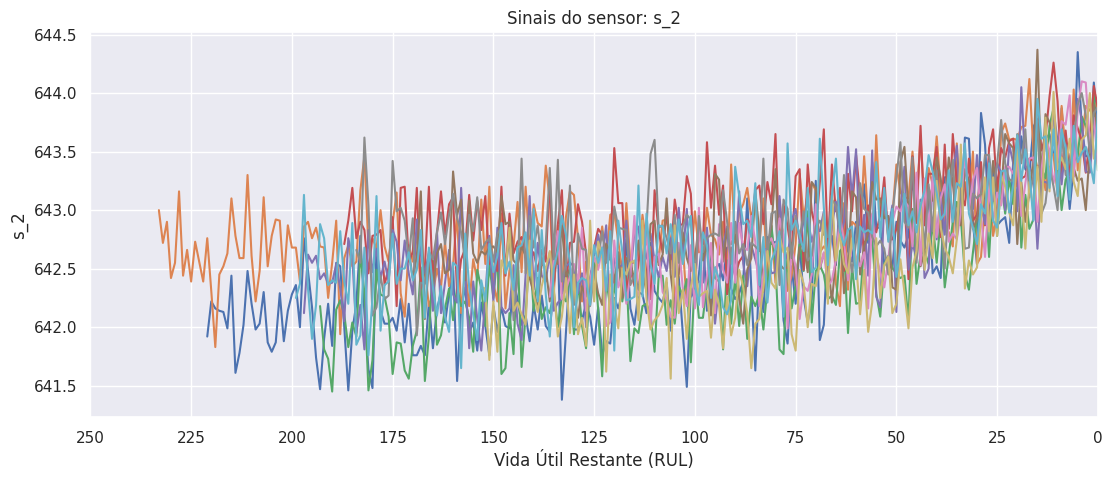

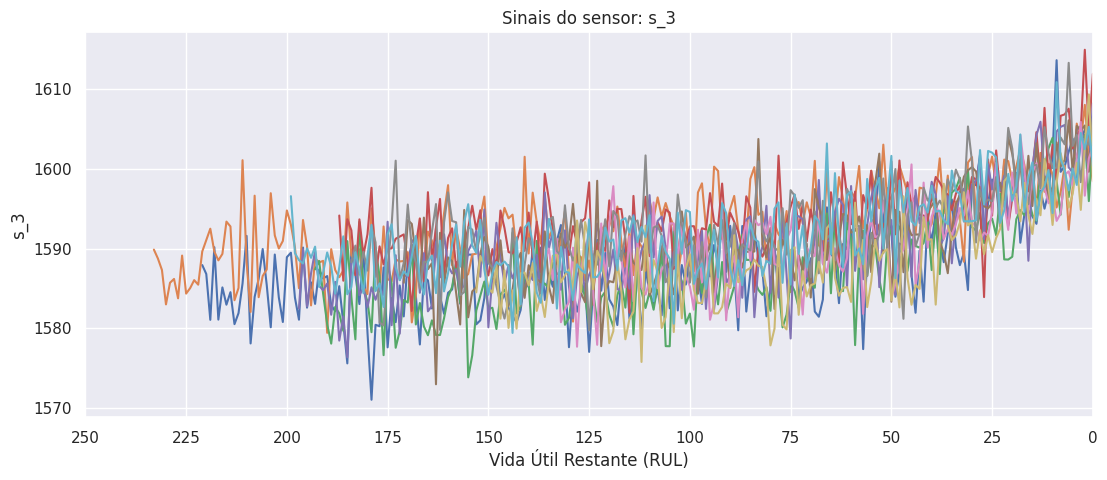

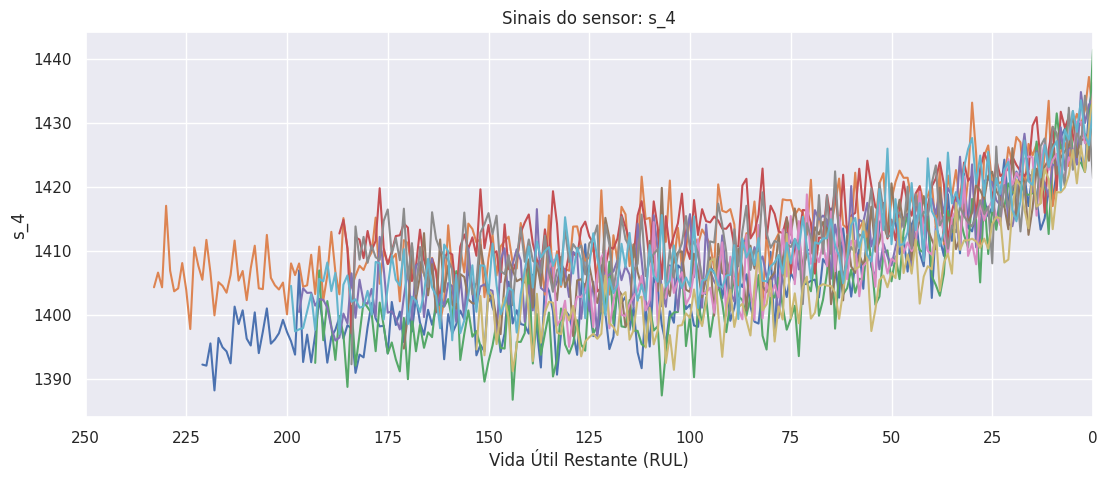

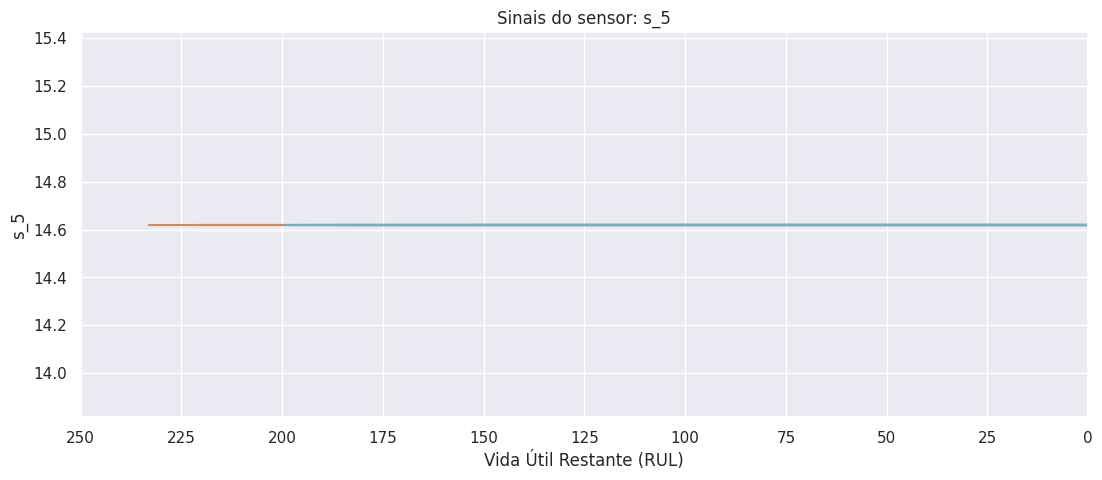

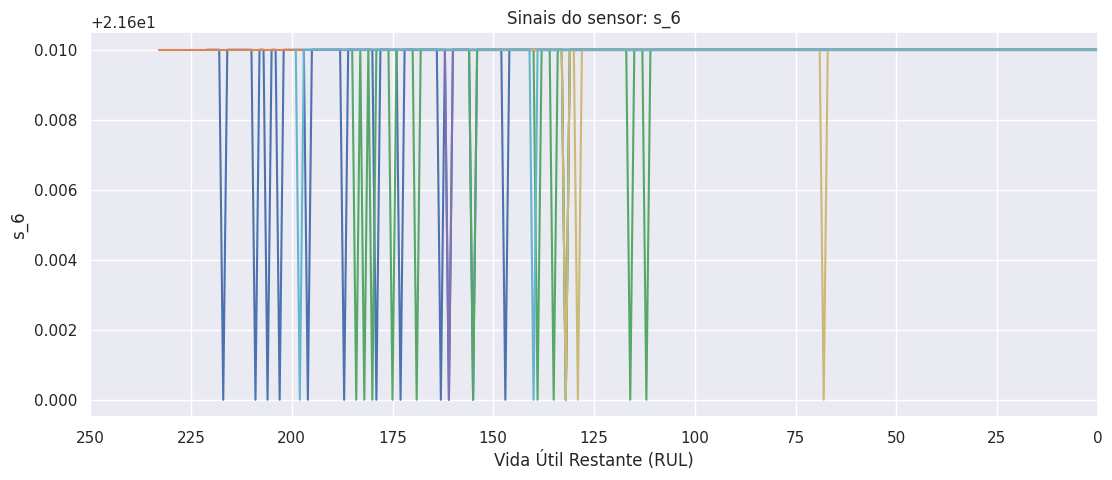

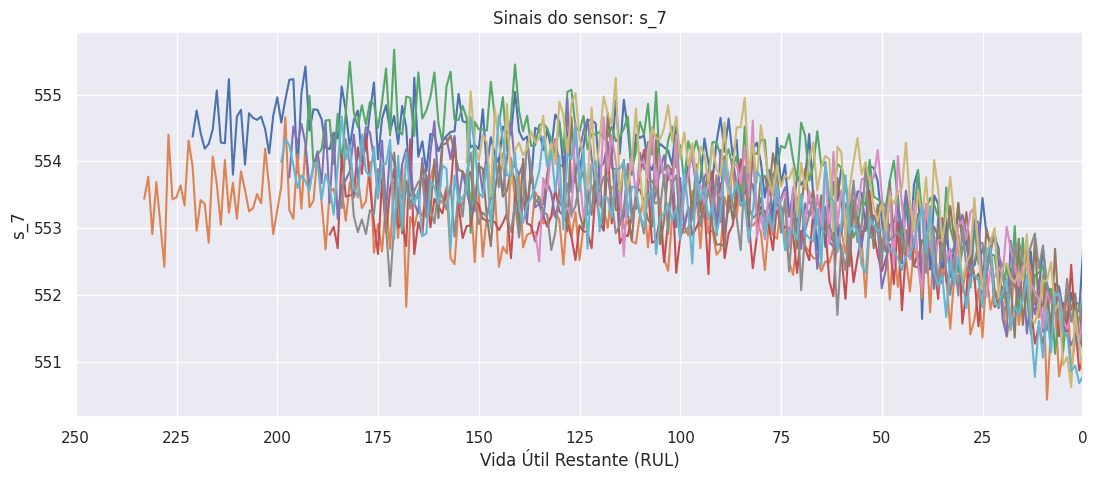

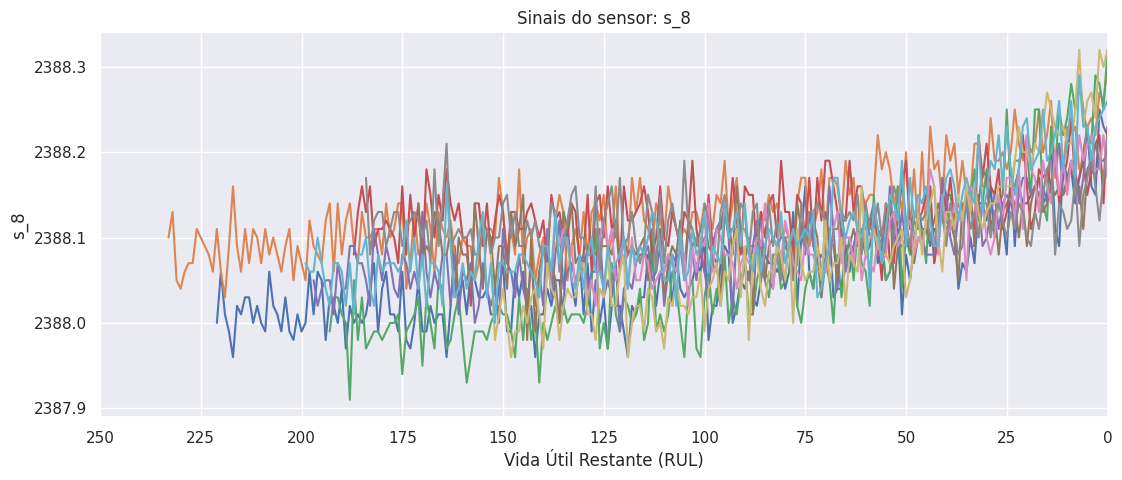

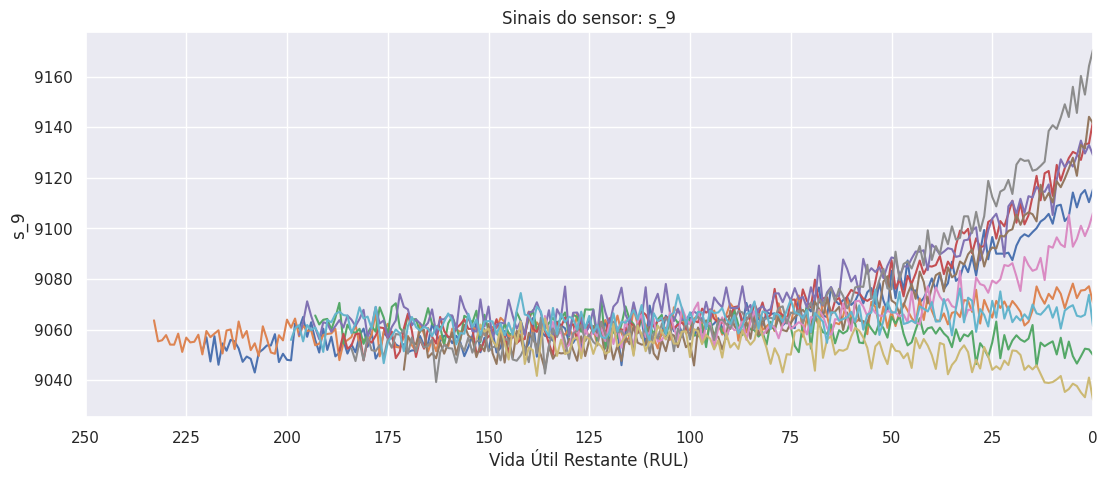

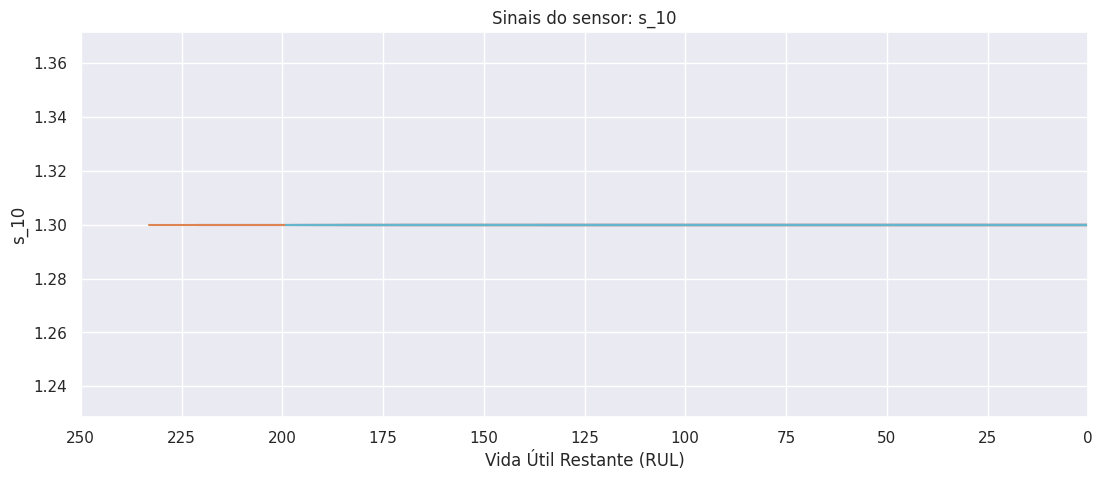

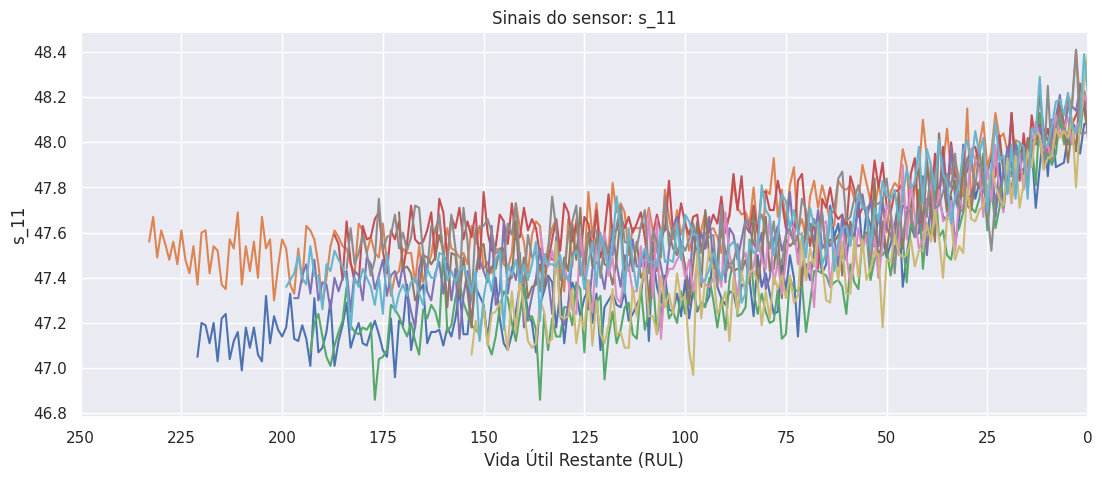

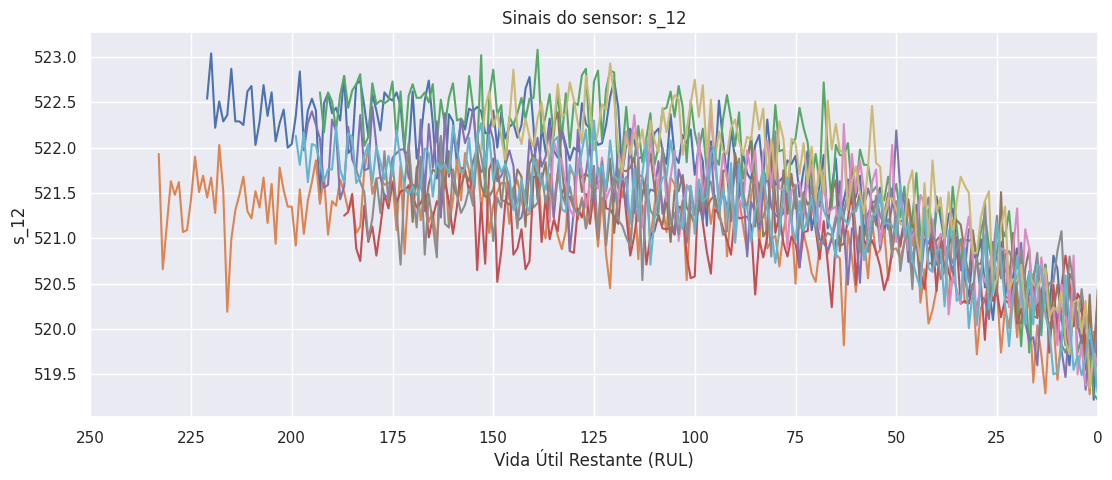

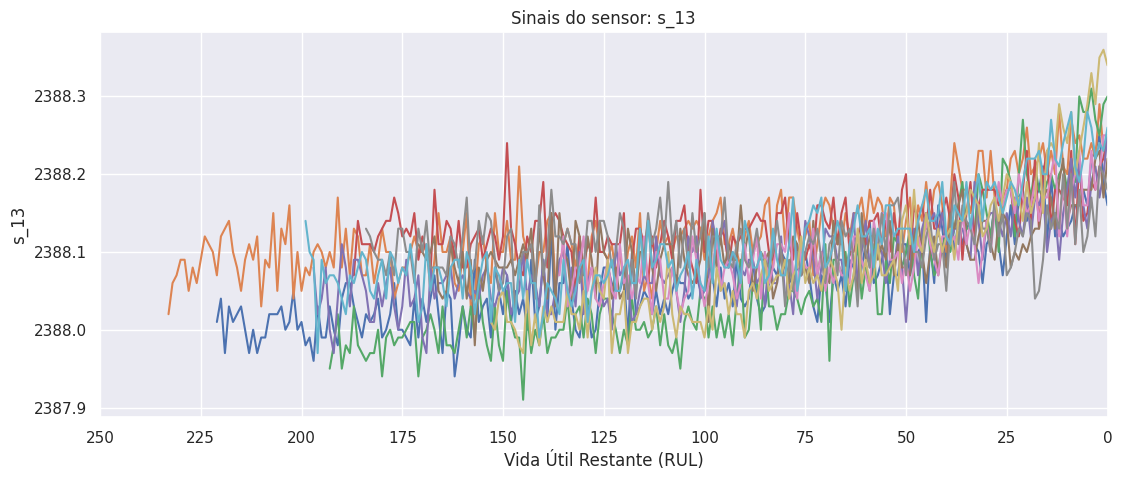

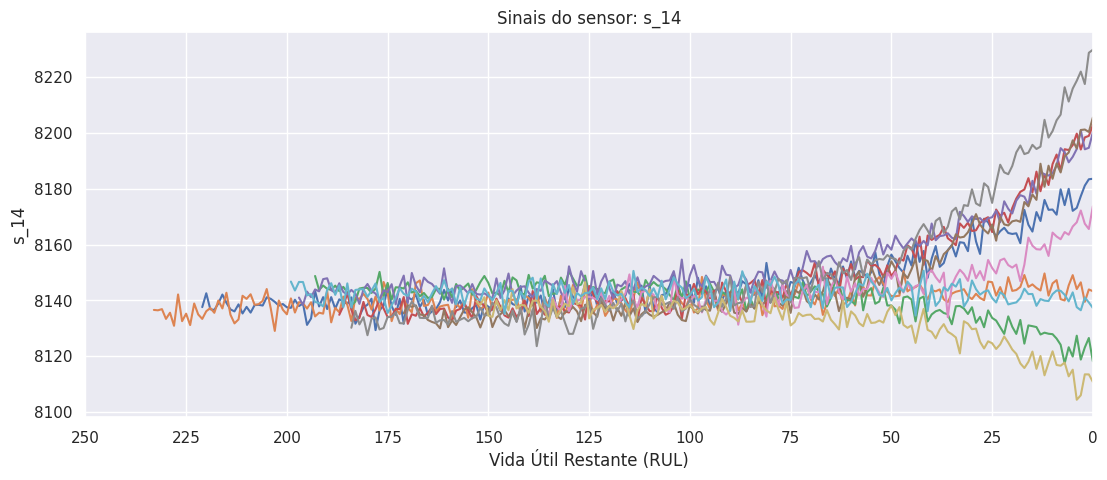

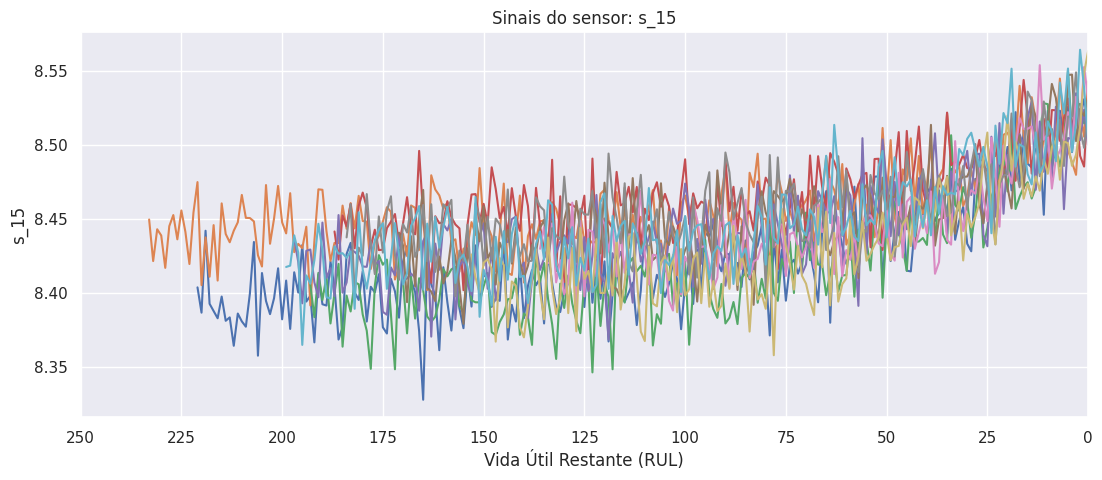

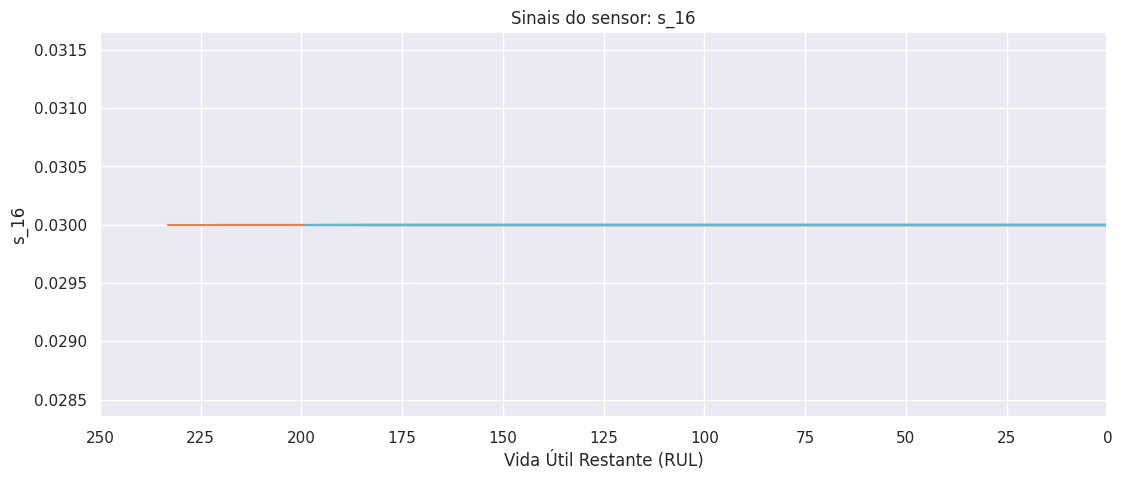

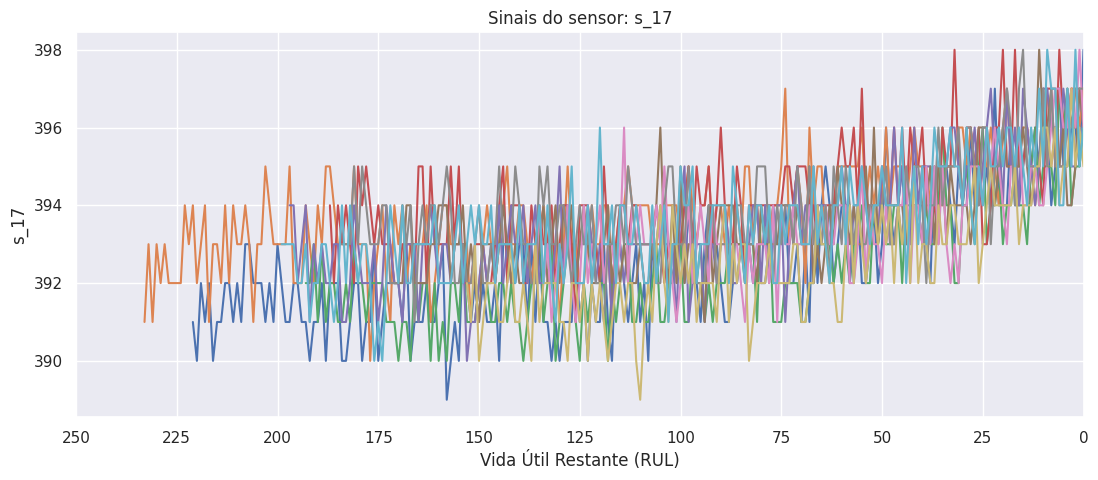

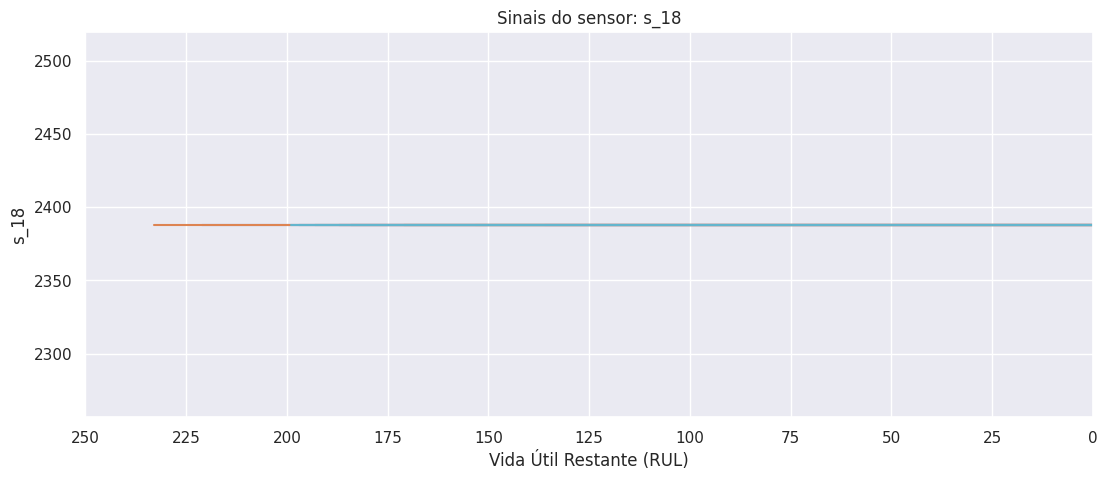

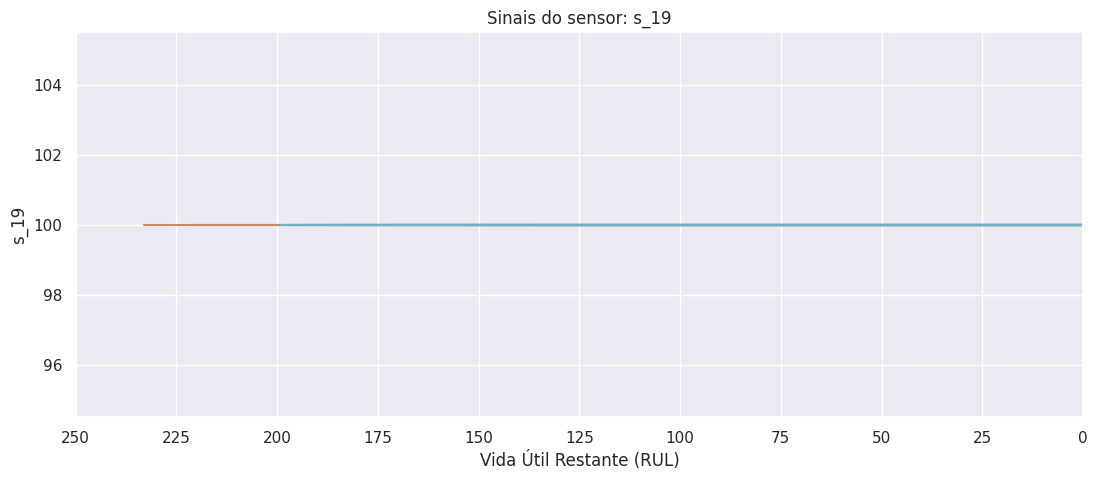

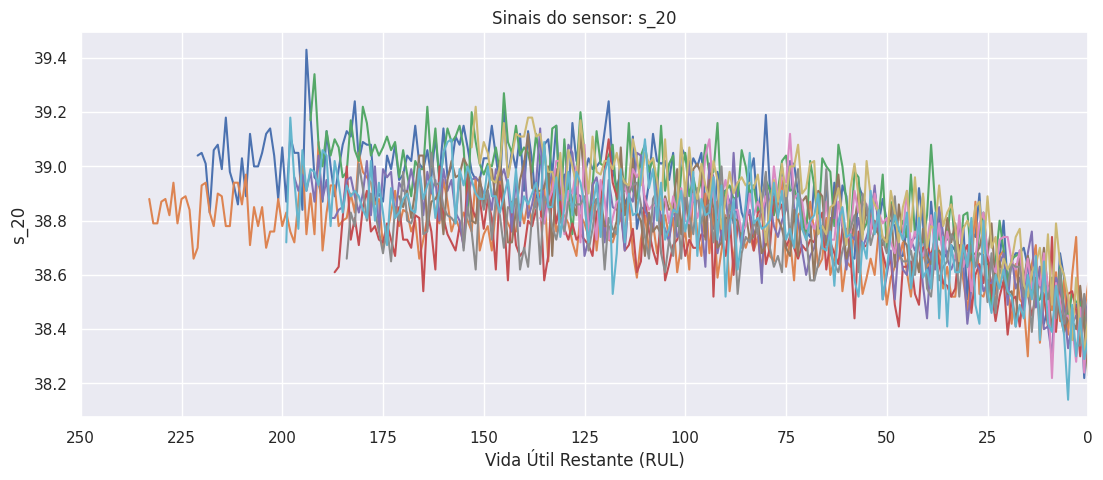

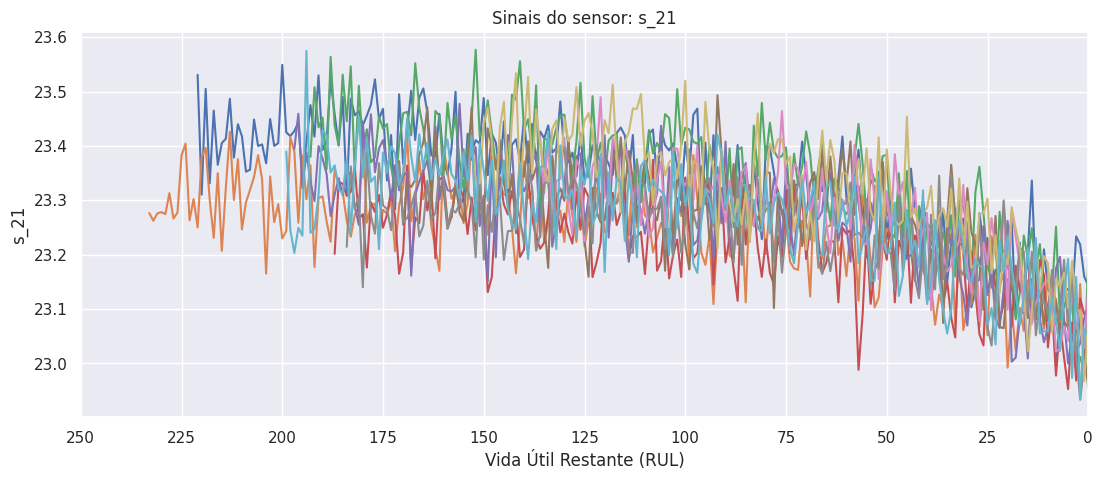

In [100]:
for nome_sensor in sensor_names:
    plotar_sensor(nome_sensor)


OS graficos dos sensores 1, 5, 10, 16, 18 e 19 parecem semelhantes; a linha reta indica que os sensores não contêm informações úteis

O sensor 2 mostra uma tendência crescente; um padrão semelhante pode ser visto nos sensores 3, 4, 8, 11, 13, 15 e 17.

As leituras do sensor 6 atingem o pico para baixo às vezes, mas não parece haver uma relação clara com a diminuição do RUL.

O sensor 7 mostra uma tendência de declínio, que também pode ser observada nos sensores 12, 20 e 21.

O sensor 9 tem um padrão semelhante ao sensor 14.

Com base em nossa Análise Exploratória de Dados, podemos determinar que os sensores 1, 5, 6, 10, 16, 18 e 19 não contêm informações relacionadas à RUL, pois os valores dos sensores permanecem constantes ao longo do tempo.

# **Regressão Linear**


A **Regressão Linear** é um modelo supervisionado que busca encontrar a relação entre variáveis independentes (**X**) e uma variável dependente (**y**), ajustando uma reta (ou hiperplano, no caso de múltiplas variáveis) que minimiza o erro das previsões.

No nosso projeto, ela foi utilizada para prever a **RUL (Remaining Useful Life)** de motores, a partir das leituras de sensores e variáveis de configuração.

---
### Etapas
1. **Função de Avaliação:** Implementamos `evaluate()` para calcular **RMSE** e **R²**.
2. **Seleção de Variáveis:** Removemos sensores irrelevantes (`drop_sensors`) e variáveis de índice/configuração.
3. **Divisão dos Dados:**
   - `X_train` e `y_train` para treino do modelo.
   - `X_test` e `y_test` para teste, usando apenas o último ciclo de cada motor.
4. **Treinamento do Modelo:** Ajuste com `LinearRegression()`.
5. **Avaliação:** Comparação de desempenho no treino e teste.
6. **Análise de Coeficientes:** Identificação de quais variáveis mais impactam na previsão de RUL.

---


In [101]:
# Função de avaliação
def evaluate(y_true, y_hat, label='test'):
    """Calcula RMSE e R² e exibe no console."""
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print(f"{label} set → RMSE: {rmse:.2f}, R²: {variance:.2f}")

# Sensores a serem descartados
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names + setting_names + drop_sensors

# Conjunto de treino
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

# Conjunto de teste — apenas último ciclo de cada motor
X_test = (
    test.groupby('unit_nr')
        .last()
        .reset_index()
        .drop(drop_labels, axis=1)
)

# Criar e treinar o modelo
lm = LinearRegression()
lm.fit(X_train, y_train)

# Avaliação no treino
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

# Avaliação no teste
y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)


train set → RMSE: 44.67, R²: 0.58
test set → RMSE: 31.95, R²: 0.41


O modelo de regressão linear apresentou um R
2
  de 0.58 no conjunto de treino, indicando que ele conseguiu explicar 58% da variabilidade nos dados de treinamento. No entanto, o desempenho caiu significativamente no conjunto de teste, com um R
2
  de apenas 0.41. Essa queda de desempenho é uma evidência de sobreajuste, onde o modelo se ajustou excessivamente aos dados de treino e falhou em generalizar para dados novos. O RMSE de 31.95 ciclos no conjunto de teste sugere que as previsões do modelo têm um erro médio de aproximadamente 32 ciclos, o que pode não ser aceitável para aplicações de manutenção preditiva crítica

# **Floresta aleatória**

In [102]:
from sklearn.ensemble import RandomForestRegressor

# Criar e treinar o modelo de Random Forest
rf = RandomForestRegressor(
    n_estimators=100,      # número de árvores
    random_state=42,       # reprodutibilidade
    n_jobs=-1              # usar todos os núcleos da CPU
)
rf.fit(X_train, y_train)

# Avaliação no treino
y_hat_train_rf = rf.predict(X_train)
evaluate(y_train, y_hat_train_rf, 'train')

# Avaliação no teste
y_hat_test_rf = rf.predict(X_test)
evaluate(y_test, y_hat_test_rf)


train set → RMSE: 15.60, R²: 0.95
test set → RMSE: 34.09, R²: 0.33


O modelo de Floresta Aleatória demonstrou uma capacidade impressionante nos dados de treino, alcançando um R
2
  de 0.95 e um RMSE de apenas 15.60 ciclos. No entanto, seu desempenho decaiu drasticamente no conjunto de teste, com um R
2
  de 0.33 e um RMSE de 34.09 ciclos. Essa disparidade indica um sobreajuste severo. O modelo "memorizou" os dados de treino e falhou em generalizar para dados novos. Isso sugere que, embora a Floresta Aleatória seja um modelo poderoso, a configuração atual não é ideal para o problema. O próximo passo crucial seria a otimização de hiperparâmetros para encontrar um equilíbrio entre o desempenho no treino e a generalização para o teste.

# **Rede Neural (MLP Regressor)**

In [112]:

# --- 1. Normalização ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 2. Rede Neural ---
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1
)

mlp.fit(X_train_scaled, y_train)

# --- 3. Função de avaliação no formato desejado ---
def avaliar_modelo(nome, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{nome} → RMSE: {rmse:.2f}, R²: {r2:.2f}")

# --- 4. Avaliação ---
y_train_pred = mlp.predict(X_train_scaled)
avaliar_modelo("train set", y_train, y_train_pred)

y_test_pred = mlp.predict(X_test_scaled)
avaliar_modelo("test set", y_test, y_test_pred)


train set → RMSE: 48.33, R²: 0.96
test set → RMSE: 52.83, R²: 0.95


A Rede Neural (MLP Regressor) apresentou um desempenho significativamente superior em comparação com os modelos anteriores. Com um R
2
  de 0.96 no treino e 0.95 no teste, e um RMSE no conjunto de teste de 52.83 ciclos, o modelo demonstra uma notável capacidade de generalização. A pequena diferença entre o desempenho nos conjuntos de treino e teste indica que o modelo conseguiu capturar as relações complexas nos dados sem sofrer de sobreajuste. Isso confirma que a arquitetura da rede neural, combinada com o pré-processamento de normalização, é a mais adequada para prever a vida útil restante (RUL) neste projeto, superando as limitações dos modelos de regressão linear e floresta aleatória.